In [1]:
# We install the libraries we will use
!pip install -q transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.7 MB/s eta 0:00:00


In [2]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from tqdm import trange
import pandas as pd
import numpy as np
from random import sample
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

seed = 42
torch.manual_seed(seed)

In [3]:
label_mapping = {'get_smells': 0, 'get_smells_date': 1, 'report': 2, 'info': 3}

The segments of code and functions "label_mapping", "plot", "compute_metrics", "get_metrics" and "input_test_weighted_predictions_ita" were taken from the "input_testing.ipynb" file, dedicated to input testing of the english NLU model.

In [4]:
def plot(intent):
  intent_series = pd.Series(intent)
  intent_series.value_counts().plot(kind='bar')

In [5]:
import evaluate

accuracy_metric = evaluate.load('accuracy')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')
f1_metric = evaluate.load('f1')
mcc_metric = evaluate.load('matthews_correlation')

def compute_metrics(preds, label_ids):
  accuracy = accuracy_metric.compute(predictions=preds, references=label_ids)['accuracy']
  precision = precision_metric.compute(predictions=preds, references=label_ids, average=None)['precision']
  precision_w = precision_metric.compute(predictions=preds, references=label_ids, average='weighted')['precision']
  recall = recall_metric.compute(predictions=preds, references=label_ids, average=None)['recall']
  recall_w = recall_metric.compute(predictions=preds, references=label_ids, average='weighted')['recall']
  f1 = f1_metric.compute(predictions=preds, references=label_ids, average=None)['f1']
  f1_w = f1_metric.compute(predictions=preds, references=label_ids, average='weighted')['f1']
  mcc = mcc_metric.compute(predictions=preds, references=label_ids)['matthews_correlation']

  return accuracy, precision, precision_w, recall, recall_w, f1, f1_w, mcc

In [6]:
tokenizer = RobertaTokenizer.from_pretrained(
    'roberta-base',
    do_lower_case = True
)

def get_metrics(df, col_req, col_intent):
  preds = []

  for index, row in df.iterrows():
    request_ids = tokenizer.encode_plus(
                              row[col_req],
                              add_special_tokens = True,
                              max_length = 32,
                              pad_to_max_length = True,
                              return_attention_mask = True,
                              return_tensors = 'pt'
                        )

    input_ids = torch.clone(request_ids['input_ids']).detach().to(model.device)

    with torch.no_grad():
        output = model(input_ids)

    predictions = torch.softmax(output.logits, dim=1)
    confidence = predictions.max(dim=1).values.detach().cpu().numpy()
    predicted_class = predictions.argmax(dim=1).flatten().cpu().numpy()

    preds.append(predicted_class[0])

  test_accuracy, test_precision, test_precision_w, test_recall, test_recall_w, test_f1, test_f1_w, test_mcc = compute_metrics(preds, df[col_intent].values)

  print('- Test Accuracy: {:.4f}'.format(test_accuracy))

  print('\n- Test Precision weighted: {:.4f}'.format(test_precision_w))
  print('\t- Test Precision [class get_smell]: {:.4f}'.format(test_precision[0]))
  print('\t- Test Precision [class get_smell_date]: {:.4f}'.format(test_precision[1]))
  print('\t- Test Precision [class report]: {:.4f}'.format(test_precision[2]))
  print('\t- Test Precision [class info]: {:.4f}'.format(test_precision[3]))

  print('\n- Test Recall weighted: {:.4f}'.format(test_recall_w))
  print('\t- Test Recall [class get_smell]: {:.4f}'.format(test_recall[0]))
  print('\t- Test Recall [class get_smell_date]: {:.4f}'.format(test_recall[1]))
  print('\t- Test Recall [class report]: {:.4f}'.format(test_recall[2]))
  print('\t- Test Recall [class info]: {:.4f}'.format(test_recall[3]))

  print('\n- Test F1 weighted: {:.4f}'.format(test_f1_w))
  print('\t- Test F1 [class get_smell]: {:.4f}'.format(test_f1[0]))
  print('\t- Test F1 [class get_smell_date]: {:.4f}'.format(test_f1[1]))
  print('\t- Test F1 [class report]: {:.4f}'.format(test_f1[2]))
  print('\t- Test F1 [class info]: {:.4f}'.format(test_f1[2]))

  print('\n- Test MCC: {:.4f}\n'.format(test_mcc))

In [7]:
# Load the italian model
model = RobertaForSequenceClassification.from_pretrained("alfcan/CADOCS_NLU_ita")

In [8]:
dfParaphrased_ita = pd.read_csv("https://raw.githubusercontent.com/alfcan/CADOCS_NLU_Model/dev/dataset/paraphrased_italian_dataset.csv", sep = ';')


dfParaphrased_ita['intent'] = dfParaphrased_ita['intent'].map(label_mapping)
dfParaphrased_ita.head()

,original_request,paraphrased_request,intent
0,dimmi quali Community smells sono presenti in ...,dimmi quali Community smels sono presenti tn q...,1
1,Che tipo di community smells riesci a rilevare?,Che tipo do community smalls riesci g rilevare?,3
2,Da dopo il 10/05/2022 quali community smells s...,Da dopo in 10pm / 05 / 2022 quali community sm...,1
3,"Ciao, quali sono i community smells in data 12...","Ciao, quali sono i comunity smells in date 12t...",1
4,Mostrami l'ultima esecuzione.,Mostrami L ' ultima esecuzione.,2


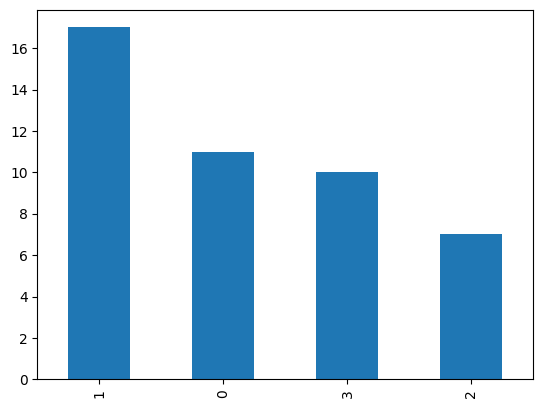

In [9]:
plot(dfParaphrased_ita['intent'])

In [10]:
get_metrics(dfParaphrased_ita, "paraphrased_request", "intent")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


- Test Accuracy: 0.9333

- Test Precision weighted: 0.9476
	- Test Precision [class get_smell]: 0.7857
	- Test Precision [class get_smell_date]: 1.0000
	- Test Precision [class report]: 1.0000
	- Test Precision [class info]: 1.0000

- Test Recall weighted: 0.9333
	- Test Recall [class get_smell]: 1.0000
	- Test Recall [class get_smell_date]: 0.8235
	- Test Recall [class report]: 1.0000
	- Test Recall [class info]: 1.0000

- Test F1 weighted: 0.9341
	- Test F1 [class get_smell]: 0.8800
	- Test F1 [class get_smell_date]: 0.9032
	- Test F1 [class report]: 1.0000
	- Test F1 [class info]: 1.0000

- Test MCC: 0.9146



In [11]:
dfParaphrased_ita_input_testing = pd.read_csv("https://raw.githubusercontent.com/alfcan/CADOCS_NLU_Model/dev/dataset/paraphrased_italian_dataset_input_testing.csv", sep = ';')

dfParaphrased_ita_input_testing['intent'] = dfParaphrased_ita_input_testing['intent'].map(label_mapping)

dfParaphrased_ita_input_testing.head()

,original_request,paraphrased_request,intent
0,Quali community smells ci sono in questa repos...,Quali comunity smels ci sono ir questa reposit...,0
1,Mostrami l'ultimo report,Mostrami La ' ultimo rapor,2
2,"CADOCS, mostrami i risultati della tua ultima ...","CADOCS, mostrami I’ve risultati della tua ulti...",2
3,"Salve, richiedo un report relativo al vostro u...","Salve, richiedo an report relativo AL vostro u...",2
4,Quali community smells sei in grado di indenti...,Quali communit smell's sei it grado di indenti...,3


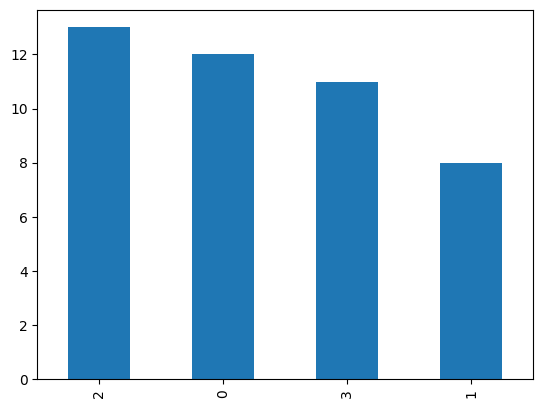

In [12]:
plot(dfParaphrased_ita_input_testing['intent'])

In [13]:
get_metrics(dfParaphrased_ita_input_testing, "paraphrased_request", "intent")

- Test Accuracy: 0.9545

- Test Precision weighted: 0.9579
	- Test Precision [class get_smell]: 0.9231
	- Test Precision [class get_smell_date]: 1.0000
	- Test Precision [class report]: 0.9286
	- Test Precision [class info]: 1.0000

- Test Recall weighted: 0.9545
	- Test Recall [class get_smell]: 1.0000
	- Test Recall [class get_smell_date]: 0.7500
	- Test Recall [class report]: 1.0000
	- Test Recall [class info]: 1.0000

- Test F1 weighted: 0.9522
	- Test F1 [class get_smell]: 0.9600
	- Test F1 [class get_smell_date]: 0.8571
	- Test F1 [class report]: 0.9630
	- Test F1 [class info]: 0.9630

- Test MCC: 0.9404



After analyzing the performances on the two datasets separately, we merge them together to have a complete view of the model capacities.

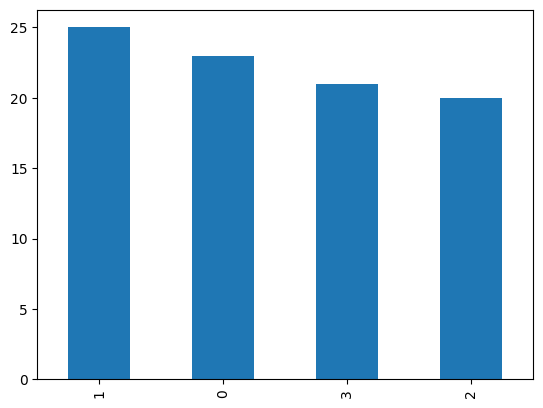

In [14]:
dataframes_ita=[dfParaphrased_ita, dfParaphrased_ita_input_testing]
dfParaphrased_ita_input_testing_merged=pd.concat(dataframes_ita)
plot(dfParaphrased_ita_input_testing_merged['intent'])

In [15]:
get_metrics(dfParaphrased_ita_input_testing_merged, "paraphrased_request", "intent")

- Test Accuracy: 0.9438

- Test Precision weighted: 0.9510
	- Test Precision [class get_smell]: 0.8519
	- Test Precision [class get_smell_date]: 1.0000
	- Test Precision [class report]: 0.9524
	- Test Precision [class info]: 1.0000

- Test Recall weighted: 0.9438
	- Test Recall [class get_smell]: 1.0000
	- Test Recall [class get_smell_date]: 0.8000
	- Test Recall [class report]: 1.0000
	- Test Recall [class info]: 1.0000

- Test F1 weighted: 0.9426
	- Test F1 [class get_smell]: 0.9200
	- Test F1 [class get_smell_date]: 0.8889
	- Test F1 [class report]: 0.9756
	- Test F1 [class info]: 0.9756

- Test MCC: 0.9284



In [16]:
def input_test_weighted_predictions_ita(df):

  correct_get_smells, correct_get_smells_date, correct_report, correct_info=0, 0, 0, 0

  total_get_smells, total_get_smells_date, total_report, total_info=0, 0, 0, 0
  for index, row in df.iterrows():
    request_original=row["original_request"]
    request=row["paraphrased_request"]
    intent=row["intent"]

    request_ids = tokenizer.encode_plus(
                            request,
                            add_special_tokens = True,
                            max_length = 32,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt'
                      )

    input_ids = torch.clone(request_ids['input_ids']).detach().to(model.device)

    with torch.no_grad():
        output = model(input_ids)

    predictions = torch.softmax(output.logits, dim=1)
    confidence = predictions.max(dim=1).values.detach().cpu().numpy()
    predicted_class = predictions.argmax(dim=1).flatten().cpu().numpy()



    request_original_ids = tokenizer.encode_plus(
                            request_original,
                            add_special_tokens = True,
                            max_length = 32,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt'
                      )

    input_original_ids = torch.clone(request_original_ids['input_ids']).detach().to(model.device)

    with torch.no_grad():
        output_original = model(input_original_ids)

    predictions_original = torch.softmax(output_original.logits, dim=1)
    confidence_original = predictions_original.max(dim=1).values.detach().cpu().numpy()
    predicted_original_class = predictions_original.argmax(dim=1).flatten().cpu().numpy()

    if confidence < 0.55:
      print("NOT ENOUGH CONFIDENCE TO ANSWER")

    for label, index in label_mapping.items():
        if index == predicted_class:
            predicted_label = label
            break
    for label, index in label_mapping.items():
        if index == predicted_original_class:
            predicted_original_label = label
            break

    if intent == 0:
      total_get_smells=total_get_smells+1
      intent_text="get_smells"
      if "get_smells" == predicted_label == predicted_original_label and confidence_original-confidence < 0.2:
          correct_get_smells=correct_get_smells+1
    elif intent == 1:
      intent_text="get_smells_date"
      total_get_smells_date=total_get_smells_date+1
      if "get_smells_date" == predicted_label == predicted_original_label and confidence_original-confidence < 0.2:
          correct_get_smells_date=correct_get_smells_date+1
    elif intent == 2:
      intent_text="report"
      total_report=total_report+1
      if "report" == predicted_label == predicted_original_label and confidence_original-confidence < 0.2:
          correct_report=correct_report+1
    elif intent == 3:
      intent_text="info"
      total_info=total_info+1
      if "info" == predicted_label == predicted_original_label and confidence_original-confidence < 0.2:
          correct_info=correct_info+1


    print("Correct class: " + intent_text + " --- Predicted class: " + str(predicted_label) + " --- " + request+"\n Confidence: "+str(confidence)+" --- Difference between original confidence and paraphrased confidence: "+str(confidence_original-confidence)+"\n")



  percentage_get_smells=correct_get_smells/total_get_smells
  percentage_get_smells_date=correct_get_smells_date/total_get_smells_date
  percentage_report=correct_report/total_report
  percentage_info=correct_info/total_info
  print("Percentage get_smells: "+ str(percentage_get_smells))
  print("Percentage get_smells_date: "+ str(percentage_get_smells_date))
  print("Percentage report: "+ str(percentage_report))
  print("Percentage info: "+ str(percentage_info))
  sum_of_requests= total_get_smells + total_get_smells_date + total_report + total_info
  weighted_average=((percentage_get_smells*total_get_smells)+(percentage_get_smells_date*total_get_smells_date)+(percentage_report*total_report)+(percentage_info*total_info))/(sum_of_requests)
  print("Weighted average: "+str(weighted_average))

In [17]:
input_test_weighted_predictions_ita(dfParaphrased_ita)

Correct class: get_smells_date --- Predicted class: get_smells_date --- dimmi quali Community smels sono presenti tn questa repository Link dal 1 / 05 / 2022
 Confidence: [0.988555] --- Difference between original confidence and paraphrased confidence: [0.00203168]

Correct class: info --- Predicted class: info --- Che tipo do community smalls riesci g rilevare?
 Confidence: [0.8237305] --- Difference between original confidence and paraphrased confidence: [0.07559121]

Correct class: get_smells_date --- Predicted class: get_smells_date --- Da dopo in 10pm / 05 / 2022 quali community smells sono presenti nella repository LINK?
 Confidence: [0.97375983] --- Difference between original confidence and paraphrased confidence: [0.01377863]

Correct class: get_smells_date --- Predicted class: get_smells_date --- Ciao, quali sono i comunity smells in date 12th / 12 / 20 del progetto LINK? Grazie in anticipo.
 Confidence: [0.98589003] --- Difference between original confidence and paraphrased 

In [18]:
input_test_weighted_predictions_ita(dfParaphrased_ita_input_testing)

Correct class: get_smells --- Predicted class: get_smells --- Quali comunity smels ci sono ir questa repository?
 Confidence: [0.5983915] --- Difference between original confidence and paraphrased confidence: [0.09387064]

Correct class: report --- Predicted class: report --- Mostrami La ' ultimo rapor
 Confidence: [0.88832074] --- Difference between original confidence and paraphrased confidence: [0.02558696]

Correct class: report --- Predicted class: report --- CADOCS, mostrami I’ve risultati della tua ultima esecuzione.
 Confidence: [0.99178517] --- Difference between original confidence and paraphrased confidence: [-8.445978e-05]

Correct class: report --- Predicted class: report --- Salve, richiedo an report relativo AL vostro ultimo compito in esecuzione. Grazie i anticipo.
 Confidence: [0.9880903] --- Difference between original confidence and paraphrased confidence: [0.00107437]

Correct class: info --- Predicted class: info --- Quali communit smell's sei it grado di indentifi

In [19]:
input_test_weighted_predictions_ita(dfParaphrased_ita_input_testing_merged)

Correct class: get_smells_date --- Predicted class: get_smells_date --- dimmi quali Community smels sono presenti tn questa repository Link dal 1 / 05 / 2022
 Confidence: [0.988555] --- Difference between original confidence and paraphrased confidence: [0.00203168]

Correct class: info --- Predicted class: info --- Che tipo do community smalls riesci g rilevare?
 Confidence: [0.8237305] --- Difference between original confidence and paraphrased confidence: [0.07559121]

Correct class: get_smells_date --- Predicted class: get_smells_date --- Da dopo in 10pm / 05 / 2022 quali community smells sono presenti nella repository LINK?
 Confidence: [0.97375983] --- Difference between original confidence and paraphrased confidence: [0.01377863]

Correct class: get_smells_date --- Predicted class: get_smells_date --- Ciao, quali sono i comunity smells in date 12th / 12 / 20 del progetto LINK? Grazie in anticipo.
 Confidence: [0.98589003] --- Difference between original confidence and paraphrased 